# Data Analysis


To develop a classifier that can decide which one of two prompts will be prefered by a user we have to identify what data is relevant for a user to like or dislike a text. This data analysis aims to sort out the relevant data for our task.

We have the following assumptions to solve the task:
- The liking of a text is not random but follows certain patterns
- These patterns can be identified through data analysis
- The patterns are related to measurable text characteristics
- Users have consistent preferences that can be learned
- The preferences can be generalized across different texts


Possibly relevant data: 
1. Amount of nouns in response
2. Amount of adjectives in response
3. sentence-sentiment
4. amount of words per response
5. amount of (., ,, -, !, etc.) in response
6. amount of letters per response
7. amount of vowels per response

## Possible alternative
Embedd the texts and try to train a deep neural network on this

In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler


KeyboardInterrupt: 

In [2]:
# Import nouns and adjectives
from nltk.corpus import wordnet as wn
import nltk

# Ensure WordNet is downloaded
nltk.download('wordnet')

# Function to extract all nouns
def get_nouns():
    nouns = set()
    for synset in wn.all_synsets(pos=wn.NOUN):
        for lemma in synset.lemmas():
            name = lemma.name()
            # Replace underscores with empty string to concatenate words
            name = name.replace('_', '')
            nouns.add(name)
    return nouns

# Function to extract all adjectives
def get_adjectives():
    adjectives = set()
    for synset in wn.all_synsets(pos=wn.ADJ):
        for lemma in synset.lemmas():
            adjectives.add(lemma.name())
    return adjectives

# Get nouns and adjectives
nouns = get_nouns()
adjectives = get_adjectives()

print("Nouns: ", list(nouns)[:10])
print("Adjectives: ", list(adjectives)[:10])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\siran\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Nouns:  ['BattleofNaseby', 'Iraniandinar', 'sinusrectus', 'propositus', 'mesocolon', 'Peromyscusleucopus', 'transgressor', 'farrier', 'roominess', 'solver']
Adjectives:  ['initial', 'uncomprehended', 'hand-to-hand', 'vestiary', 'indefatigable', 'agonal', 'executable', 'predigested', 'flickering', 'long-branched']


In [3]:
# Load the different datasets
df_train = pd.read_csv('../Data/LLM Classification Finetuning/train.csv')
df_test = pd.read_csv('../Data/LLM Classification Finetuning/test.csv')

# Display basic information about the datasets
print("Training dataset shape:", df_train.shape)
print("Test dataset shape:", df_test.shape) 
print("Dataset columns:", df_train.columns)


Training dataset shape: (57477, 9)
Test dataset shape: (3, 4)
Dataset columns: Index(['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b',
       'winner_model_a', 'winner_model_b', 'winner_tie'],
      dtype='object')


## 1. Amount of nouns in response

In [4]:
def count_nouns(sentence):
    words = sentence.split(" ")
    count = 0
    for word in words:
        if word.lower() in nouns:
            count += 1
    return count

    
def count_nouns_rows(row):
    a_count = count_nouns(row["response_a"])
    b_count = count_nouns(row["response_b"])
    return a_count, b_count


In [5]:
# The apply function returns a Series/array, need to convert to separate columns
counts = df_train.apply(count_nouns_rows, axis=1)
df_train["count_a"] = [x[0] for x in counts]
df_train["count_b"] = [x[1] for x in counts]

In [6]:
print(df_train[:3])

      id             model_a         model_b  \
0  30192  gpt-4-1106-preview      gpt-4-0613   
1  53567           koala-13b      gpt-4-0613   
2  65089  gpt-3.5-turbo-0613  mistral-medium   

                                              prompt  \
0  ["Is it morally right to try to have a certain...   
1  ["What is the difference between marriage lice...   
2  ["explain function calling. how would you call...   

                                          response_a  \
0  ["The question of whether it is morally right ...   
1  ["A marriage license is a legal document that ...   
2  ["Function calling is the process of invoking ...   

                                          response_b  winner_model_a  \
0  ["As an AI, I don't have personal beliefs or o...               1   
1  ["A marriage license and a marriage certificat...               0   
2  ["Function calling is the process of invoking ...               0   

   winner_model_b  winner_tie  count_a  count_b  
0               0 

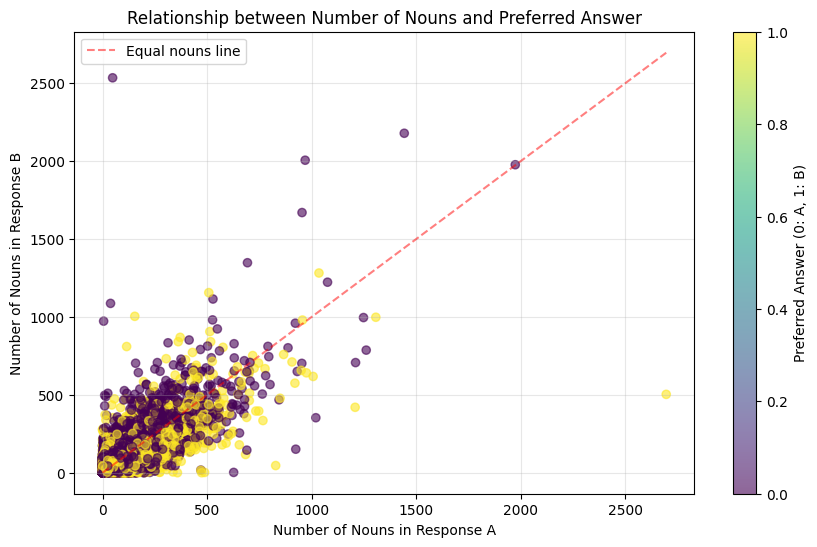


Average nouns when answer A preferred: count_a    68.497209
count_b    57.574113
dtype: float64

Average nouns when answer B preferred: count_a    56.118943
count_b    62.227461
dtype: float64


In [10]:
# Create a figure
plt.figure(figsize=(10, 6))

# Create scatter plot
plt.scatter(df_train['count_a'], df_train['count_b'], c=df_train['winner_model_a'], cmap='viridis', alpha=0.6)

plt.xlabel('Number of Nouns in Response A')
plt.ylabel('Number of Nouns in Response B')
plt.title('Relationship between Number of Nouns and Preferred Answer')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Preferred Answer (0: A, 1: B)')

# Add a diagonal line for reference
max_nouns = max(df_train['count_a'].max(), df_train['count_b'].max())
plt.plot([0, max_nouns], [0, max_nouns], 'r--', alpha=0.5, label='Equal nouns line')

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print some statistics
print("\nAverage nouns when answer A preferred:", 
      df_train[df_train['winner_model_a']==1][['count_a', 'count_b']].mean())
print("\nAverage nouns when answer B preferred:",
      df_train[df_train['winner_model_a']==0][['count_a', 'count_b']].mean())


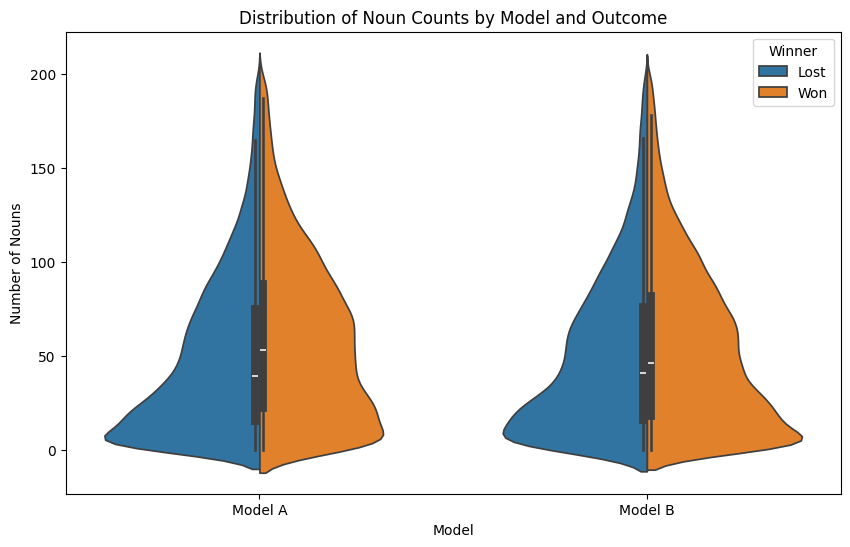

In [21]:
# Create figure
plt.figure(figsize=(10, 6))

limit = 200

# Reshape data for violin plot
plot_data_a = pd.DataFrame({
    'Nouns': df_train[df_train['count_a'] < limit]['count_a'],
    'Model': 'Model A',
    'Winner': df_train[df_train['count_a'] < limit]['winner_model_a'].map({1: 'Won', 0: 'Lost'})
})

plot_data_b = pd.DataFrame({
    'Nouns': df_train[df_train['count_b'] < limit]['count_b'], 
    'Model': 'Model B',
    'Winner': df_train[df_train['count_b'] < limit]['winner_model_a'].map({0: 'Won', 1: 'Lost'})
})

plot_data = pd.concat([plot_data_a, plot_data_b])

# Create violin plot
sns.violinplot(data=plot_data, x='Model', y='Nouns', hue='Winner', split=True)

plt.title('Distribution of Noun Counts by Model and Outcome')
plt.xlabel('Model')
plt.ylabel('Number of Nouns')

plt.show()


In [16]:
# T-Test
t_stat, p_val = stats.ttest_ind(df_train.loc[df_train['winner_model_a'] == 0, 'count_a'], df_train.loc[df_train['winner_model_a'] == 1, 'count_a'])
print(f"T-Test for count_a: p-value = {p_val}")

T-Test for count_a: p-value = 3.79027917014266e-100


It seems that the count of nouns has some influence in the selection of the answer.